This code is a Qiskit implementation, inspired by [Pennylane first tutorial](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html).

# Objective 
We want te recreate a NOT gate, using a 3-parameters, parametrized quantum circuit, by classical optimization of its parameters.

# Quantum circuit
As we have seen, qubit state are always initialized in the state $|0\rangle=\begin{bmatrix} 1 \\ 0\end{bmatrix}$

Now consider the following quantum gate :

$$U(\theta, \phi, \lambda) = \begin{bmatrix} \cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
            e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda)}\cos(\frac{\theta}{2})
     \end{bmatrix}$$

This is the most general *one qubit* quamtum gate, from which you can obtain all other *one qubit* canonical gates.

# Protocole :
1. First we will apply this gate to the initial state $|0\rangle$, such that we obtain the new state $|\psi\rangle$ : $|\psi\rangle=U_3|0\rangle$.
2. Second we will measure the expectation value  $\langle\psi|\sigma_z|\psi\rangle$ along the axis Z, with the pauli-Z operator :

$$\begin{split}\sigma_z =
\begin{bmatrix} 1 &  0 \\
                0 & -1
\end{bmatrix}.\end{split}$$

# Solution
First by replacing $|\psi\rangle$ in the expression $\langle\psi|\sigma_z|\psi\rangle$ we have :

$$\langle\psi|\sigma_z|\psi\rangle = \langle0|U_3^{\dagger}\sigma_zU_3|0\rangle$$

By recalling that $\dagger$ is the complex conjugate, and with a bit of maths, we can show that the solution is :
$$\langle\psi|\sigma_z|\psi\rangle=cos^2(\theta/2)-sin^2(\theta/2)$$

Several things to note here :
1. First, since we are measuring on the Z-basis, the solution only depends on the parameter $\theta$ ! Hence, the two other parameters are not needed.
2. We can easily deduce optimal parameter value by plotting some parameter values  :
     - For $\theta=0$ $\rarr$  $cos^2(\theta/2)-sin^2(\theta/2)=1$
     - For $\theta=\pi/2$ $\rarr$  $cos^2(\theta/2)-sin^2(\theta/2)=0$
     - For $\theta=\pi$ $\rarr$  $cos^2(\theta/2)-sin^2(\theta/2)=-1$
3. Remark that, assuming $\phi$ and $\lambda$ are zero, this will gives exactly the Pauli-X gate :
$$U(\pi, 0, 0)=\begin{split}\sigma_x =
\begin{bmatrix} 0 &  1 \\
                1 & 0
\end{bmatrix}.\end{split}$$
4. Trivially, the solution we hope the algorithm will find, is $\theta=\pi$ ! Because
by definition :
$$\sigma_x|0\rangle=|1\rangle=\begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

# Cost function
Since the solution we want must be the one associated with the minmum in our cost functin, without realizing it, we just encoded our **cost function** in the **expectation value**!


# Import libraries

In [90]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import SPSA
from qiskit.quantum_info import Statevector



# Implementing the circuit

We have to create a circuit, that will take `Parameter` object as argument of the `U` gate.

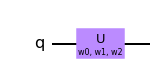

In [91]:
# Quantum circuit with parameters

def circuit(qc, W):        
    qc.u( W[0],  W[1],  W[2], 0) # Unitary gate with 3 paramters
    return qc


qc = QuantumCircuit(1) # Create the circuit, with one qubit
nbParameter = 3
w_param = [Parameter(f'w{i}') for i in range(nbParameter)] # Create a list of Parameter objects
qc = circuit(qc, w_param)
qc.draw('mpl')

# State vector

The purpose of this tutorial is to illustrate how the quamtum circuit relate
to the mathematics.

We will use the `statevector_simulator` that can actually compute the mathematical state vector of the quantum circuit as gates are applied.
As always we will use the `execute` function to run the circuit.

*NB : in practise, you cannot access to the vector state of a real quantum circuit*

Since we will have to perform this operation many times, it will be
easier if we create a function `get_statevector` :

In [92]:
def get_statevector(qc, w, param_w, backend):
    """
    Binds the parameters of a parametrized quantum circuit to their values and execute
    the circuit with the statevector simulator.
    """

    # Bind parameter values to the circuit
    params_dict = {p:v for (p,v) in zip(param_w, w)}
    grounded_circ = qc.bind_parameters(params_dict)

    # Execute and get state vector
    result = execute(grounded_circ, backend).result()
    statevector = result.get_statevector(0)

    return statevector.reshape(2, 1)

# Example 
In the following box, we use this function in order to display the state vector for some value of the parameters :

In [93]:
# Backend simulator
sv_sim = Aer.get_backend('statevector_simulator')

W_init = [0.01, 0.1, 0.1]
psi_ket = get_statevector(qc, W_init, w_param, sv_sim)

print(psi_ket)


[[0.9999875+0.j        ]
 [0.004975 +0.00049917j]]


As you can see, since we put very low values of the $\theta$ parameters the real part of $|\psi\rangle$ is very close to one, as expected.

*NB : you can verify that the result would not change if you modifyed $\phi$ or $\lambda$*.

# Expectation value

Now it is time to implement the expectation value, as mentioned earlier
of the pauli-Z operator :

$$\begin{split}\sigma_z =
\begin{bmatrix} 1 &  0 \\
                0 & -1
\end{bmatrix}.\end{split}$$

We want to compute $\langle\psi|\sigma_z|\psi\rangle$ :

In [94]:
Z_matrix = np.array([[1, 0], [0, -1]]) # Pauli-Z operator
psi_bra = np.conj(psi_ket.T)
print('<psi| =', psi_bra)
print('---------------')
print('Z =', Z_matrix)
print('---------------')
print('|psi> =', psi_ket)
print('---------------')
excpectedValue = psi_bra@Z_matrix@psi_ket
print('<Z> =', np.real(excpectedValue)[0][0])

<psi| = [[0.9999875-0.j         0.004975 -0.00049917j]]
---------------
Z = [[ 1  0]
 [ 0 -1]]
---------------
|psi> = [[0.9999875+0.j        ]
 [0.004975 +0.00049917j]]
---------------
<Z> = 0.9999500004166653


# Cost function

Now we need a function that will compute the cost, as being the
expectation value of the total quantum circuit along the Z-axis.

In [95]:
def cost_function(w, w_param, qc, backend):
    
    # Compute state vector
    statevectors = get_statevector(qc, w, w_param, backend)
    
    # Expectation value 
    psi = statevectors.reshape(2, 1)
    excpectedValue = (np.conj(psi.T)@Z_matrix@psi)[0]
        
    return np.real(excpectedValue[0])


# Get handles on the statevector simulator
sv_sim = Aer.get_backend('statevector_simulator')

# Compute cost
initial_weights = np.array([0.011, 0.012, 0.1])
result = cost_function(initial_weights, w_param, qc, sv_sim)
print(result)

0.9999395006100393


# Optimizer

Now that we have define everything, it's time to **optimize** !

First, traditionally in machine learning, optimizer need a `callback` function, that will give usefull information during the optimization process :


In [114]:
def optimizer_callback(nb_fct_eval, params, fct_value, stepsize, step_accepted, train_history):
    """
    Callback used to record the weight parameters at each epoch and to print
    the progress of the loss. 
    
    :param nb_fct_eval: The number of function evaluations
    :param params: The parameters
    :param fct_value: The function value
    :param stepsize: The stepsize
    :param step_accepted: Whether the step was accepted
    :param train_history: A list to record the training parameters 
    """
    train_history.append(params)
    
    if ((nb_fct_eval - 1) %15 == 0) or ((nb_fct_eval-1)/3==1):
        print(f'  > Epoch {int((nb_fct_eval - 1) / 3)} - loss: {fct_value:0.4f}')
    



Now we will optimize ! To do so we will use `SPSA`, a built-in classical optimizer in Qiskit.
You can find optimizers along with their description in [Qiskit documentation](https://sooluthomas.github.io/testTranslation/aqua/optimizers.html).

In [115]:
initial_weights = np.array([0.011, 0.012, 0.1])

# Backend
sv_sim = Aer.get_backend('statevector_simulator')

train_history = []
num_iter =200

# Initialize the SPSA optimizer
optimizer = SPSA(maxiter=num_iter, blocking=True, callback=lambda n, p, v, ss, sa: optimizer_callback(n, p, v, ss, sa, train_history))

# Optimize the PQC, it should take less than a minute
point, loss, nfev = optimizer.optimize(len(initial_weights), lambda params: cost_function(params, w_param, qc, sv_sim), initial_point=initial_weights)


  > Epoch 1 - loss: 0.8025
  > Epoch 5 - loss: -0.7940
  > Epoch 10 - loss: -0.2127
  > Epoch 15 - loss: -0.5054
  > Epoch 20 - loss: -0.6529
  > Epoch 25 - loss: -0.7393
  > Epoch 30 - loss: -0.7952
  > Epoch 35 - loss: -0.8339
  > Epoch 40 - loss: -0.8619
  > Epoch 45 - loss: -0.8831
  > Epoch 50 - loss: -0.8995
  > Epoch 55 - loss: -0.9126
  > Epoch 60 - loss: -0.9232
  > Epoch 65 - loss: -0.9319
  > Epoch 70 - loss: -0.9392
  > Epoch 75 - loss: -0.9453
  > Epoch 80 - loss: -0.9506
  > Epoch 85 - loss: -0.9551
  > Epoch 90 - loss: -0.9591
  > Epoch 95 - loss: -0.9625
  > Epoch 100 - loss: -0.9656
  > Epoch 105 - loss: -0.9683
  > Epoch 110 - loss: -0.9707
  > Epoch 115 - loss: -0.9728
  > Epoch 120 - loss: -0.9747
  > Epoch 125 - loss: -0.9765
  > Epoch 130 - loss: -0.9781
  > Epoch 135 - loss: -0.9795
  > Epoch 140 - loss: -0.9808
  > Epoch 145 - loss: -0.9820
  > Epoch 150 - loss: -0.9831
  > Epoch 155 - loss: -0.9841
  > Epoch 160 - loss: -0.9850
  > Epoch 165 - loss: -0.9859
  >